In [1]:
import numpy as np
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt

Moment:   0%|          | 0/6435 [00:00<?, ?it/s]

MLE:   0%|          | 0/6435 [00:00<?, ?it/s]

Kernel reflect:   0%|          | 0/6435 [00:00<?, ?it/s]

Moment: (0.9595180679107066, 0.9723262040929214)
MLE: (0.9519212662850784, 1.0070233076562265)


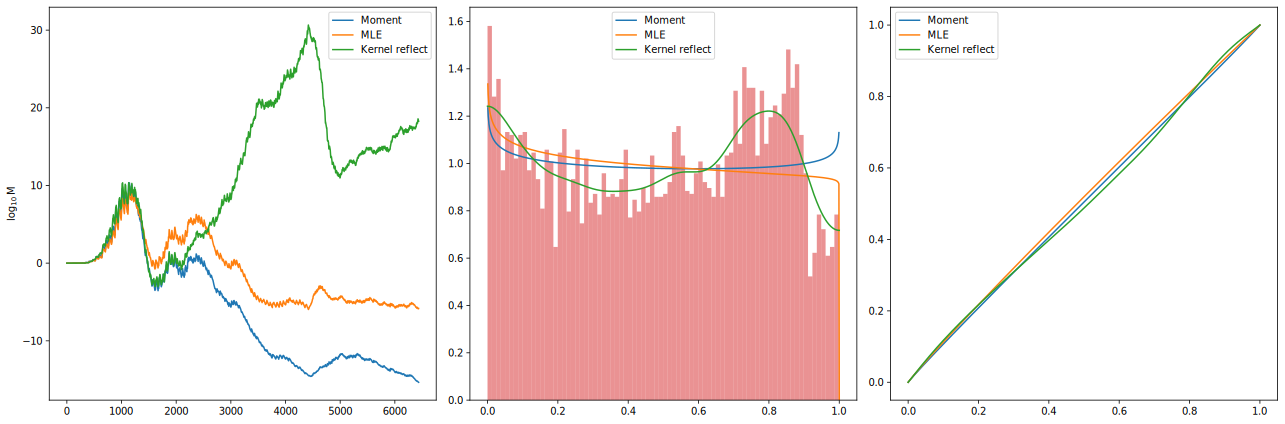

In [2]:
from online_cp import PluginMartingale
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib_inline.backend_inline import set_matplotlib_formats
# Set the desired output format
set_matplotlib_formats('svg')
from tqdm.notebook import tqdm
from scipy.stats import beta

min_sample_size = 1000
mixing_exponent = 3

martingale_mom = PluginMartingale(method='beta', beta_method='moment', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, warnings=False)
martingale_mle = PluginMartingale(method='beta', beta_method='mle', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, warnings=False)

bandwidth='silverman'
martingale_gaussian_kernel_reflect = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, bandwidth=bandwidth, warnings=False)
martingale_gaussian_kernel_logit = PluginMartingale(method='kernel', kernel_method='logit', edge_adjustment=0.001, min_sample_size_kernel=min_sample_size, mixing_exponent=mixing_exponent, bandwidth=bandwidth, warnings=False)


p_values = np.load('data_martingale_experiment/p_values_satelite_orig.npy')
N = len(p_values)

# a = 0.8
# b = 3
# # np.random.seed(2024)
# N = 1000
# p_values = np.random.beta(a, b, size=N)

mom_protection = []
mle_protection = []
reflect_protection = []
logit_protection = []

for p in tqdm(p_values, desc='Moment'):
    martingale_mom.update_martingale_value(p)
    mom_protection.append(martingale_mom.B_n(p))
for p in tqdm(p_values, desc='MLE'):
    martingale_mle.update_martingale_value(p)
    mle_protection.append(martingale_mle.B_n(p))
for p in tqdm(p_values, desc='Kernel reflect'):
    martingale_gaussian_kernel_reflect.update_martingale_value(p)
    reflect_protection.append(martingale_gaussian_kernel_reflect.B_n(p))
# for p in tqdm(p_values, desc='Kernel logit'):
#     martingale_gaussian_kernel_logit.update_martingale_value(p)
#     logit_protection.append(martingale_gaussian_kernel_logit.B_n(p))

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18,6))
axs[0].plot(martingale_mom.log10_martingale_values, label='Moment')
axs[0].plot(martingale_mle.log10_martingale_values, label='MLE')
axs[0].plot(martingale_gaussian_kernel_reflect.log10_martingale_values, label='Kernel reflect')
# axs[0].plot(martingale_gaussian_kernel_logit.log10_martingale_values, label='Kernel logit')

axs[0].set_ylabel(r'$\log_{10}M$')
axs[0].legend()

prange = np.linspace(0, 1, num=1000)
axs[1].plot(
    prange,
    martingale_mom.b_n(prange),
    label='Moment'
)
axs[1].plot(
    prange,
    martingale_mle.b_n(prange),
    label='MLE'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_reflect.b_n(prange),
    label='Kernel reflect'
)
# axs[1].plot(
#     prange,
#     martingale_gaussian_kernel_logit.b_n(prange),
#     label='Kernel logit'
# )
# axs[1].plot(prange, beta.pdf(prange, a, b), label='True PDF', color='red', linestyle='--')
axs[1].hist(p_values, density=True, alpha=0.5, bins=int(np.sqrt(N)))
axs[1].legend()

axs[2].plot(
    prange,
    martingale_mom.B_n(prange),
    label='Moment'
)
axs[2].plot(
    prange,
    martingale_mle.B_n(prange),
    label='MLE'
)
axs[2].plot(
    prange,
    martingale_gaussian_kernel_reflect.B_n(prange),
    label='Kernel reflect'
)
# axs[2].plot(
#     prange,
#     martingale_gaussian_kernel_logit.B_n(prange),
#     label='Kernel logit'
# )
# axs[2].plot(prange, beta.cdf(prange, a, b), label='True CDF', color='red', linestyle='--')
axs[2].legend()
fig.tight_layout()

print(f'Moment: {martingale_mom.ahat, martingale_mom.bhat}')
print(f'MLE: {martingale_mle.ahat, martingale_mle.bhat}')

In [3]:
# Come up with a suitable messy density, and ensure that it has an analytic cdf for convenience.
class CustomDistribution(rv_continuous):
    def _pdf(self, x):
        return martingale_gaussian_kernel_reflect.b_n(x)
    
    def _cdf(self, x):
        return martingale_gaussian_kernel_reflect.B_n(x)
    
custom_dist = CustomDistribution(a=0, b=1, name='custom_dist')
samples = custom_dist.rvs(size=10000)

(array([1.15846652, 0.96038675, 0.88935815, 0.88135493, 0.90536459,
        0.96338796, 1.00740569, 1.15546531, 1.24950318, 0.83333559]),
 array([3.88784334e-04, 1.00348514e-01, 2.00308243e-01, 3.00267973e-01,
        4.00227703e-01, 5.00187432e-01, 6.00147162e-01, 7.00106891e-01,
        8.00066621e-01, 9.00026350e-01, 9.99986080e-01]),
 <BarContainer object of 10 artists>)

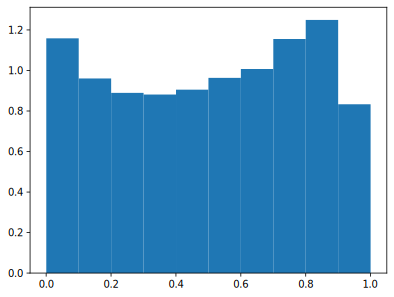

In [4]:
plt.hist(samples, density=True)

# Now apply the protection procedure to the p-values
We can not use the martingale class as the betting function should be the known density. 

In [5]:
min_sample_size = 10
martingale = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, bandwidth=bandwidth, warnings=False)
calibration_martingale = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, bandwidth=bandwidth, warnings=False)
plugin_calibration_martingale = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, bandwidth=bandwidth, warnings=False)
uniformity_check_martingale = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, bandwidth=bandwidth, warnings=False)

logM = [0]
calLogM = [0]
p_values = []
protected_p_values = []
plugin_protected_p_values = []

for p, u in tqdm(zip(samples, np.random.uniform(0,1,len(samples))), total=len(samples)):
    protected_p = custom_dist.cdf(p)
    plugin_protected_p = martingale.B_n(p)
    calLogM.append(calLogM[-1] + np.log(custom_dist.pdf(protected_p)))
    logM.append(logM[-1] + np.log(custom_dist.pdf(p)))
    martingale.update_martingale_value(p)
    calibration_martingale.update_martingale_value(protected_p)
    plugin_calibration_martingale.update_martingale_value(plugin_protected_p)
    p_values.append(p)
    protected_p_values.append(protected_p)
    plugin_protected_p_values.append(plugin_protected_p)
    uniformity_check_martingale.update_martingale_value(u)

  0%|          | 0/10000 [00:00<?, ?it/s]

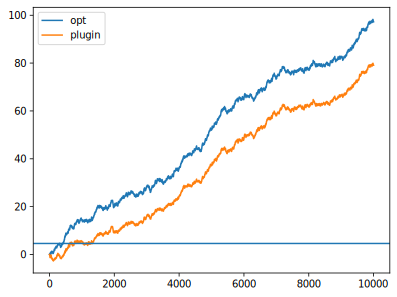

In [6]:
plt.plot(logM, label='opt')
plt.plot(martingale.log_martingale_values, label='plugin')
plt.axhline(np.log(100))
plt.legend()

Both the optimal betting, and plugin manage to transform the non-uniform p-values to something that can not be distinguished form independent samples from a uniform distribution.

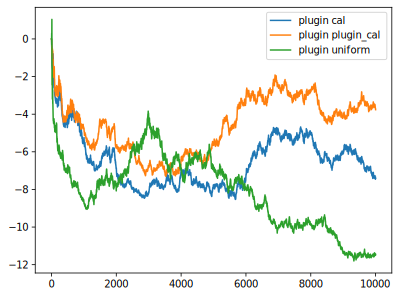

In [7]:
# plt.plot(logM, label='opt')
# plt.plot(calLogM, label='opt cal')
# plt.plot(martingale.log_martingale_values, label='plugin')
plt.plot(calibration_martingale.log_martingale_values, label='plugin cal')
plt.plot(plugin_calibration_martingale.log_martingale_values, label='plugin plugin_cal')
plt.plot(uniformity_check_martingale.log_martingale_values, label='plugin uniform')
plt.legend()

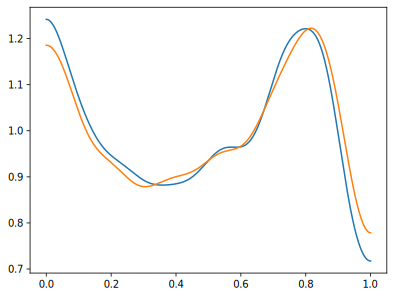

In [8]:
plt.plot(
    np.linspace(0,1,1000),
    [custom_dist.pdf(x) for x in np.linspace(0,1,1000)]
)
plt.plot(
    np.linspace(0,1,1000),
    [martingale.b_n(x) for x in np.linspace(0,1,1000)]
)

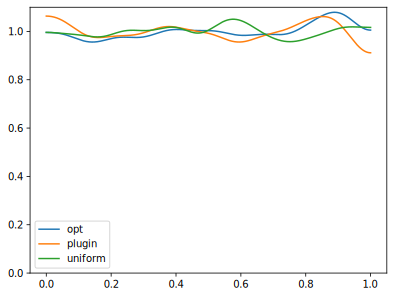

In [9]:
plt.plot(
    np.linspace(0,1,1000),
    calibration_martingale.b_n(np.linspace(0,1,1000)), 
    label='opt'
)
plt.plot(
    np.linspace(0,1,1000),
    plugin_calibration_martingale.b_n(np.linspace(0,1,1000)),
    label='plugin'
)
plt.plot(
    np.linspace(0,1,1000),
    uniformity_check_martingale.b_n(np.linspace(0,1,1000)), 
    label='uniform'
)
plt.ylim(0,1.1)
plt.legend()

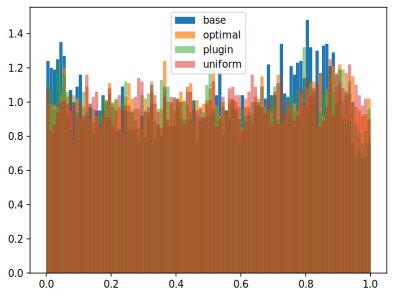

In [10]:
N = len(p_values)
plt.hist(p_values, density=True, bins=int(np.sqrt(N)), label='base')
plt.hist(protected_p_values, density=True ,alpha=0.7, bins=int(np.sqrt(N)), label='optimal')
plt.hist(plugin_protected_p_values, density=True, alpha=0.5, bins=int(np.sqrt(N)), label='plugin')
plt.hist(np.random.uniform(0,1,N), alpha=0.5, density=True, bins=int(np.sqrt(N)), label='uniform')
plt.legend()

(array([1.05049044, 0.97945728, 0.97045308, 1.02948064, 0.99446429,
        0.96745168, 0.97345448, 1.02647923, 1.06849885, 0.94444093]),
 array([4.55528860e-04, 1.00408842e-01, 2.00362154e-01, 3.00315467e-01,
        4.00268780e-01, 5.00222093e-01, 6.00175406e-01, 7.00128718e-01,
        8.00082031e-01, 9.00035344e-01, 9.99988657e-01]),
 <BarContainer object of 10 artists>)

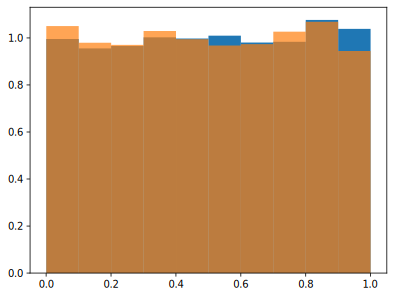

In [11]:
plt.hist(protected_p_values, density=True)
plt.hist(plugin_protected_p_values, density=True, alpha=0.7)

# Conclusion
The protection procedure works both with the optimal, and the plugin protection. This is nice to know.

# Betting according to a shifting distribution
So, we have seen that it works perfectly if we bet optimally.

(array([1.01376288, 1.01976295, 1.00201273, 1.00351275, 1.01326287,
        0.97876243, 0.97501238, 0.9762624 , 1.0000127 , 1.01776293]),
 array([1.27012087e-05, 1.00011431e-01, 2.00010161e-01, 3.00008891e-01,
        4.00007621e-01, 5.00006351e-01, 6.00005080e-01, 7.00003810e-01,
        8.00002540e-01, 9.00001270e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

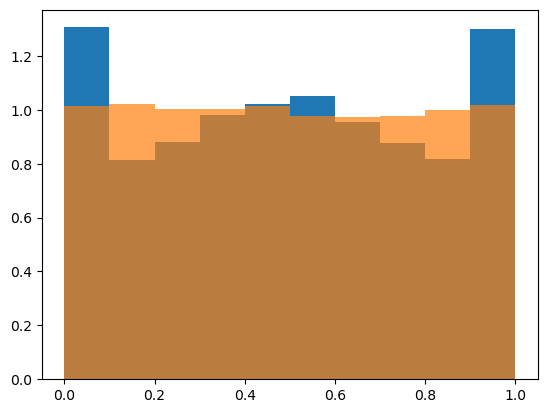

In [32]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

xrange = np.linspace(0, 1, 1000)

N = 200
M = 200
arange = np.linspace(0.1, 3.9, N)
brange = np.linspace(0.1, 3.9, M)

p_values = np.empty(shape=(N*M, ))
i = 0
for a in arange:
    for b in brange:
        p_values[i] = np.random.beta(a, b)
        i += 1

protected_p_values = np.empty_like(p_values)

i = 0
for a in arange:
    for b in brange:
        protected_p_values[i] = beta.cdf(p_values[i], a, b)
        i += 1

plt.hist(p_values, density=True)
plt.hist(protected_p_values, density=True, alpha=0.7)